# Training the Random Forest classifier using the developmental brain meta-atlas
In this script, I trained the Random Forest classifier and saved the model to disk. This allows the model to be utilized for testing in `Random_Forest_testing.ipynb`. Here I also generated **Figure 13** of the report.

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ad

from sklearn.model_selection import train_test_split
import sklearn.preprocessing as pp
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.metrics import classification_report
import functools

In [2]:
sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(7, 4))
sc.settings.verbosity = 3

-----
anndata     0.10.8
scanpy      1.10.1
-----
PIL                         10.2.0
anyio                       NA
arrow                       1.3.0
asciitree                   NA
asttokens                   NA
astunparse                  1.6.3
attr                        23.1.0
attrs                       23.1.0
babel                       2.11.0
bottleneck                  1.3.7
brotli                      1.0.9
certifi                     2024.08.30
cffi                        1.16.0
charset_normalizer          2.0.4
cloudpickle                 3.0.0
colorama                    0.4.6
comm                        0.2.1
cycler                      0.10.0
cython_runtime              NA
dask                        2024.7.0
dateutil                    2.8.2
debugpy                     1.6.7
decorator                   5.1.1
defusedxml                  0.7.1
executing                   0.8.3
fastjsonschema              NA
fqdn                        NA
h5py                        3.9.0
id

#### I imported the training dataset and created a duplicate variable. The first variable, `train`, will be used for feature selection, while the second, `trainraw`, will be designated for actual training. This dataset was generated in the notebook titled `fron_no_adolescence_to_final_training_dataset.ipynb`.

In [3]:
train = sc.read_h5ad(
    '/hpc/hers_basak/rnaseq_data/Silettilab/samples/final_useful_datasets/noAdolescence_nocc_noclusters_ThirdManualAnnotations_Interneurons.h5ad')
trainraw = train.copy()

#### I imported the test dataset to ensure only the genes common to both datasets are selected, preventing errors during processing.

In [4]:
test = sc.read_h5ad(
    '/hpc/hers_basak/rnaseq_data/Silettilab/proj/GBM/output/data/GBM_Tumor_Dissociation.h5ad')

## Step 1: Initial adjustments.

#### I changed the index of `test.var` from ensemble IDs to gene names.

In [5]:
test.var = (
    test.var
    .reset_index()                      
    .rename(columns={'index': 'ensemble_ids'})  
    .set_index('Gene')                  
)

/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/miniconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:767: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['marker-DsRed', 'marker-Cherry', 'marker-GFP', 'marker-Tomato', 'marker-cre']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)


#### I made unique test names.

In [6]:
test.var.index = test.var.index.astype(str)
test.var_names_make_unique(join="_")

#### I randomly selected 5000 cells for cell class to ensure a more balanced representation across all classes.

In [7]:
cell_counts = train.obs['ThirdManualAnnotations'].value_counts()
allsampledindices = []

for cell_class, count in cell_counts.items():
    cells_of_class = train.obs[train.obs['ThirdManualAnnotations'] == cell_class]

    sampled_cells = cells_of_class.sample(n=min(count, 5000), replace=False, random_state = 42)
    allsampledindices.append(sampled_cells.index)

allsampledindices = np.hstack(allsampledindices)
train = train[allsampledindices]
trainraw = trainraw[allsampledindices]

## Step 2: Feature selection.

#### I removed cell cycling genes.

In [8]:
ccGenesHuman = np.loadtxt('/hpc/hers_basak/rnaseq_data/Silettilab/samples/final_useful_datasets/ccGenesHuman.txt', dtype=str)
train = train[:, ~np.isin(train.var_names, ccGenesHuman)]

In [9]:
cc2 = ['CCND2', 'TFDP2']
train = train[:, ~np.isin(train.var_names, cc2)]

#### I excluded mitochondrial, ribosomal, and tubulin genes, as well as MALAT1 and EGFR from the analysis because their overexpression in tumors could bias the classification results.

In [10]:
badGenes = [el for el in train.var_names 
            if el.startswith(('MT-', 'RP', 'TUB')) or el in {'MALAT1', 'EGFR'}]

train = train[:, ~np.isin(train.var_names, badGenes)]
len(train.var_names)

15778

#### I retained only the genes that are common to both the training and test datasets.

In [11]:
commonGenes = np.intersect1d(train.var_names, test.var_names)
train, test, trainraw = [ds[:, commonGenes] for ds in (train, test, trainraw)]

#### I normalized and logarithmized the dataset.

In [12]:
sc.pp.normalize_total(train, target_sum=1e4)
sc.pp.log1p(train)

/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/miniconda3/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:03)


#### I selected only the first 4000 most variable genes.

In [13]:
sc.pp.highly_variable_genes(train, min_mean=0.0125, max_mean=3, min_disp=0.5, n_top_genes=4000)
train = train[:, train.var.highly_variable]

extracting highly variable genes
    finished (0:00:10)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


#### I conducted a differential expression analysis followed by a filtering step to identify the most significant genes.


In [14]:
sc.tl.rank_genes_groups(train, groupby="ThirdManualAnnotations",method= 'logreg', use_raw=False)
sc.tl.filter_rank_genes_groups(train, max_out_group_fraction=0.2)

ranking genes


/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/miniconda3/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:640: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
 (0:00:17)
Filtering genes using: min_in_group_fraction: 0.25 min_fold_change: 1, max_out_group_fraction: 0.2


/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



#### I identified the 25 most expressed and specific genes for each class, excluding NaN values.

In [15]:
filtered_genes = {}
for group in train.uns['rank_genes_groups_filtered']['names'].dtype.names:
    genes = train.uns['rank_genes_groups_filtered']['names'][group]
    filtered_gene_list = [gene for gene in genes if pd.notnull(gene)]
    filtered_genes[group] = filtered_gene_list[:25]
    filtered_genes
filtered_genes = list(set([item for sublist in filtered_genes.values() for item in sublist]))

#### I imported some manually selected genes.

In [16]:
aleGenes = ['AQP4','ADGRV1','MGST1','SPARCL1','ID3','CST3','BCAN', 'VEGFA','LGALS1','LGALS3', 'ETV1','PTPRZ1','ITM2C','HOPX','VIM','CLU', 
            'CDK4','SOX2','STMN1','STMN2', 'ASCL1','HES1','NHLH1','NRXN3','RBP1', 'PLP1', 'OLIG1','OLIG2','SOX10','PDGFRA', 'ACTA2','FN1','CLDN5',
            'VXN','VWF','ITM2A', 'COL1A1','COL3A1','COL4A1', 'IGHM','IGKC', 'CD3G','CD3D','CD3E','TRAC', 'CD4', 'CD8A','GZMH','GZMK','GNLY','CD74',
            'FTL','SPP1','C1QA','C1QB','C1QC','CSF1R', 'HLA-DRA','HLA-DQB1','FOXM1','TYMS']

In [17]:
myGenes = [
    'LIX1', 'LEF1', 'HEY1', 'CRABP2', 'AMBN', 'TPD52L1', 'SNCG', 'ECEL1', 'CNFN', 'OLFM3',
    'CST3', 'TC', 'ATP1A2', 'SPARCL1', 'APOE', 'NEAT1', 'AQP4', 'SLC4A4', 'GLIS3', 'GRM3',
    'TNC', 'MGAT4C', 'LRIG1', 'GJA1', 'ACSL6', 'NPNT', 'PAQR8', 'COL5A3', 'FRMPD2',
    'CD44', 'GALNT15', 'CD38', 'DAAM2', 'ANGPT1', 'COLEC12', 'AQP1', 'HSPB8',
    'PCDH15', 'OPCML', 'CSMD3', 'CA10', 'FGF14', 'NXPH1', 'TNR', 'FGF12', 'MDGA2',
    'DNM3', 'CNTNAP5', 'NRXN3', 'SGCZ', 'COL20A1', 'CHRM3', 'PDGFRA', 'AFAP1L2', 'APOD',
    'PDGFD', 'LIPG', 'IQGAP2', 'AKAP12', 'NIPY', 'TMTC1', 'FBXO32', 'EVA1C', 'LAMA3',
    'CCDC175', 'ELAVL2', 'SRRM4', 'HES6', 'PLXNA2', 'EOMES', 'EPHA3', 'NHLH1', 'GADD45G',
    'MYT1L', 'RBFOX3', 'ELAVL4', 'SLC22A23', 'PGP13', 'KCNB2', 'NEUROG1', 'MFNG',
    'MYCL', 'RGS16', 'CREG2', 'GREM2', 'EBF2', 'NHLH2', 'LHX9', 'SPINK5', 'FNDC5',
    'EBF1', 'NRN1', 'CLMP', 'SLA', 'PPP1R17', 'SL17A6', 'NEUROD2', 'NEUROD6',
    'LGR6', 'VAV3', 'ADCY1', 'RGS6', 'KLHL4', 'GAD1', 'ATP2C2', 'GALR1', 'DBX2',
    'SLC6A11', 'ST8SIA5', 'CCDC80', 'MATN2', 'CAPS2',
    'DLL3', 'ASCL1', 'CCDC178', 'GSG1L', 'RFTN1', 'IGSF9B', 'ANGEL1', 'CASP9',
    'KIRREL3', 'DPF3', 'SLIT1', 'IRX1', 'VIPR2', 'DLX6', 'DLX6-AS1', 'DLX5', 'GAD1', 'GAD2', 'GAD45G'
]

#### I combined the genes filtered through differential expression analysis with those manually selected.

In [18]:
selectedGenes = np.unique(np.concatenate((aleGenes, filtered_genes, myGenes)))

In [19]:
selectedGenes = functools.reduce(np.intersect1d, (selectedGenes, trainraw.var_names, test.var_names))
trainraw = trainraw[:, selectedGenes]

#### I archived the selected genes for use in the `Random_Forest_testing.ipynb` notebook.

In [20]:
np.savetxt('/hpc/hers_basak/rnaseq_data/Silettilab/samples/final_useful_datasets/RF_selected_genes.txt', selectedGenes, delimiter=",", fmt='%s')

## Step 3: training of the model on `trainraw`.

#### Normalization by row

In [21]:
sc.pp.normalize_total(trainraw, target_sum=1e4)

/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/miniconda3/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


#### I extracted only the data corresponding to the selected genes and their labels into numpy arrays.

In [22]:
training = trainraw.X.A.copy()
training = np.hstack([training[:, trainraw.var.index == g] for g in selectedGenes])
y = trainraw.obs['ThirdManualAnnotations'].to_numpy()


#### The training process involved:
- **Logarithmization**: I applied``log1p` for normalization, omitting the "+1" as it is unnecessary with this technique.
- **Scaling by column**
- **Random Forest classifier**              

In [23]:
classifier = RandomForestClassifier(max_depth=40, min_samples_leaf=2, n_estimators= 400, class_weight='balanced', n_jobs=-1)
scaler = StandardScaler()
x_train, x_test, y_train, y_test = train_test_split( 
    scaler.fit_transform(np.log1p(training)),
    y,
    test_size=0.2
)

classifier.fit(x_train, y_train)
predictionsSplit = classifier.predict(x_test)
accuracySplit = classifier.score(x_test, y_test)

In [24]:
accuracySplit

0.9004050845090097

#### I printed some metrics to evaluate the classifier's performance.

In [25]:
report = classification_report(y_test, predictionsSplit, target_names=np.unique(y))
print(report)


                   precision    recall  f1-score   support

       Astrocytes       0.92      0.91      0.92      1023
             OPCs       0.97      0.98      0.97       944
Subcortical nIPCs       0.97      0.90      0.93       978
early Radial Glia       0.88      0.92      0.90      1019
 late Radial Glia       0.90      0.88      0.89      1020
            nIPCs       0.88      0.94      0.91       985
   pre-Astrocytes       0.80      0.78      0.79       640
         pre-OPCs       0.82      0.80      0.81       550

         accuracy                           0.90      7159
        macro avg       0.89      0.89      0.89      7159
     weighted avg       0.90      0.90      0.90      7159



#### I saved the model to avoid re-computation in subsequent runs.

In [26]:
joblib.dump(scaler, '/hpc/hers_basak/rnaseq_data/Silettilab/samples/final_useful_datasets/models/RF_scaler.joblib')
joblib.dump(classifier, '/hpc/hers_basak/rnaseq_data/Silettilab/samples/final_useful_datasets/models/RF.joblib')

joblib.dump(y_train, '/hpc/hers_basak/rnaseq_data/Silettilab/samples/final_useful_datasets/models/RF_y_train.joblib')
joblib.dump(y_test, '/hpc/hers_basak/rnaseq_data/Silettilab/samples/final_useful_datasets/models/RF_y_test.joblib')

joblib.dump(x_train, '/hpc/hers_basak/rnaseq_data/Silettilab/samples/final_useful_datasets/models/RF_x_train.joblib')
joblib.dump(x_test, '/hpc/hers_basak/rnaseq_data/Silettilab/samples/final_useful_datasets/models/RF_x_test.joblib')


['/hpc/hers_basak/rnaseq_data/Silettilab/samples/final_useful_datasets/models/RF_x_test.joblib']

## Figure 13

#### I evaluated on the training dataset the expression of the important genes computed in `Random_Forest_testing.ipynb`

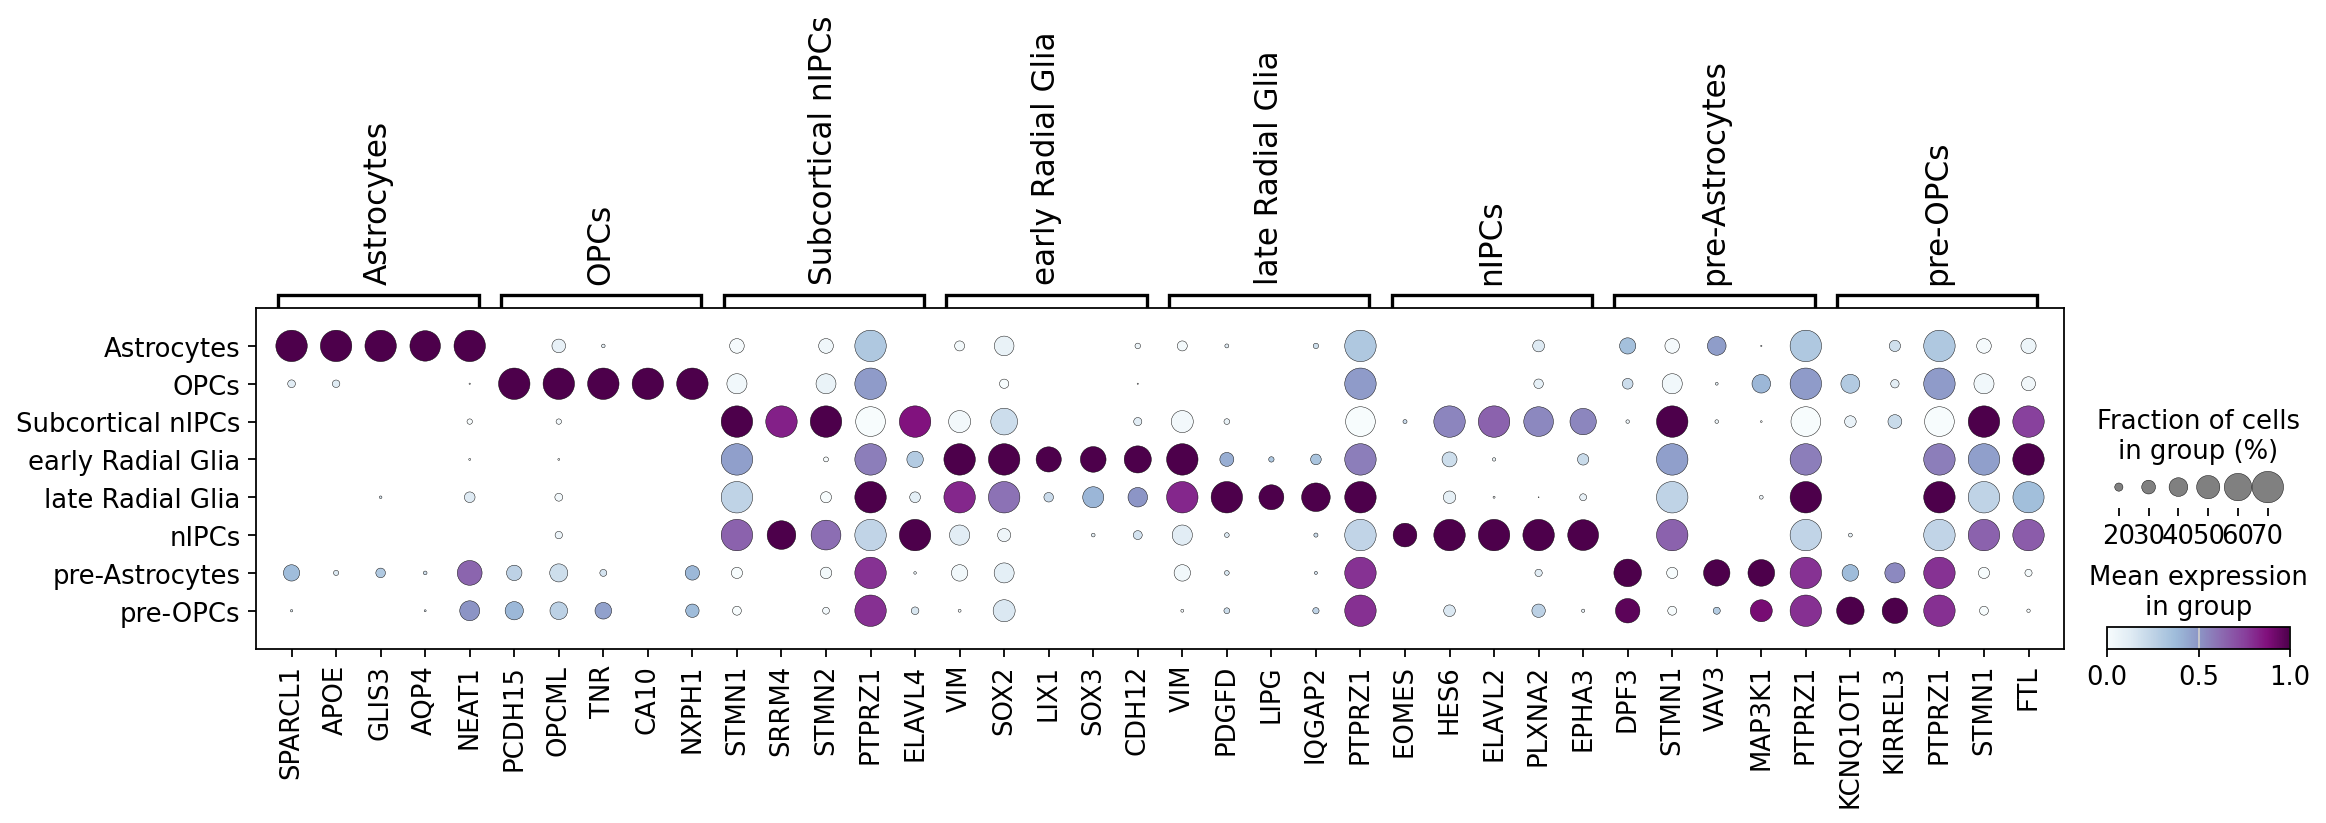

In [27]:
genes = {
    'Astrocytes': ['SPARCL1', 'APOE', 'GLIS3', 'AQP4', 'NEAT1'],
    'OPCs': ['PCDH15', 'OPCML', 'TNR', 'CA10', 'NXPH1'],
    'Subcortical nIPCs': ['STMN1', 'SRRM4', 'STMN2', 'PTPRZ1', 'ELAVL4'],
    'early Radial Glia': ['VIM', 'SOX2', 'LIX1', 'SOX3', 'CDH12'],
    'late Radial Glia': ['VIM', 'PDGFD', 'LIPG', 'IQGAP2', 'PTPRZ1'],
    'nIPCs': ['EOMES', 'HES6', 'ELAVL2', 'PLXNA2', 'EPHA3'],
    'pre-Astrocytes': ['DPF3', 'STMN1', 'VAV3', 'MAP3K1', 'PTPRZ1'],
    'pre-OPCs': ['KCNQ1OT1', 'KIRREL3', 'PTPRZ1', 'STMN1', 'FTL']
}

ax = sc.pl.dotplot(
    trainraw,
    var_names=genes,
    groupby='ThirdManualAnnotations',
    standard_scale='var',
    use_raw=False,
    color_map='BuPu',
    dot_max=0.7,
    dot_min=0.1,
    show=False
)

# uncomment this to save high quality figure
#plt.savefig('fig_13.png', dpi = 600)